# Predict whether an Email is a spam or not

In [1]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.4 MB/s 
     |████████████████████████████████| 462 kB 39.3 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

## How to handle data imbalance
1. Use technique call down sampling

In [6]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [7]:
747/4825

0.15481865284974095

## What is Down Sampling technique to handle data imbalance
* ham email count 4825
* spam email count 747
* 15% is spam email and 85% is ham email making it imbalance so down sampling technique is to pick random ham 4825 and only get 747 samples to match  spam
* that way you will have equal number of ham and spam of 747


In [8]:
# Create new dataframe spam
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
# Create new datafram ham
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham.sample(747)

,Category,Message
466,ham,great princess! I love giving and receiving or...
59,ham,Yes..gauti and sehwag out of odi series.
300,ham,Need a coffee run tomo?Can't believe it's that...
1644,ham,U WILL SWITCH YOUR FONE ON DAMMIT!!
1825,ham,Sent me ur email id soon
...,...,...
4179,ham,Two teams waiting for some players
2516,ham,Bognor it is! Should be splendid at this time ...
651,ham,Thats cool! Sometimes slow and gentle. Sonetim...
179,ham,Text her. If she doesnt reply let me know so i...


In [11]:
# Create down sample of haw to 747
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [12]:
# concentename df_spam and df_ham_downsampled to make df_balanced
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [13]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [14]:
df_balanced.sample(5)

,Category,Message
3479,ham,I can ask around but there's not a lot in term...
2372,ham,"Hmm, too many of them unfortunately... Pics ob..."
4808,spam,PRIVATE! Your 2004 Account Statement for 07849...
3828,spam,Congratulations U can claim 2 VIP row A Ticket...
3176,spam,UR GOING 2 BAHAMAS! CallFREEFONE 08081560665 a...


In [15]:
# Create a new column turn ham and spam into 0 and 1
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
426,ham,Ok. She'll be ok. I guess,0
5374,ham,Do u konw waht is rael FRIENDSHIP Im gving yuo...,0
967,ham,I am not sure about night menu. . . I know onl...,0
1382,ham,We spend our days waiting for the ideal path t...,0
1194,spam,Sex up ur mobile with a FREE sexy pic of Jorda...,1
3913,spam,You have an important customer service announc...,1
3266,spam,"44 7732584351, Do you want a New Nokia 3510i c...",1
4468,ham,"She said,'' do u mind if I go into the bedroom...",0
2502,ham,No da..today also i forgot..,0
999,ham,Then ü wait 4 me at bus stop aft ur lect lar. ...,0


In [16]:
from sklearn.model_selection import train_test_split
X = df_balanced['Message']
y = df_balanced['spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)


In [17]:
X_train.head(4)

239     New Theory: Argument wins d SITUATION, but los...
2318    Waqt se pehle or naseeb se zyada kisi ko kuch ...
1875    Would you like to see my XXX pics they are so ...
5446    I am back. Good journey! Let me know if you ne...
Name: Message, dtype: object

## Load trained model from tfhub.dev

In [18]:
# Use existing pre process

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [19]:
# Use existing encoder
bert_encode = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [20]:
# function
# get_sentence_embeding(["500$ discount. hurry up", "bhavin, are up for up volley ball game?"]) ---> 768 len vector

def get_sentence_embeding(sentences):  
  preprocessed_text = bert_preprocess(sentences)
  return bert_encode(preprocessed_text)

get_sentence_embeding([
  "500$ discount. hurry up", 
  "bhavin, are up for up volley ball game?"
])

{'default': <tf.Tensor: shape=(2, 768), dtype=float32, numpy=
 array([[-0.8435166 , -0.5132724 , -0.88845706, ..., -0.7474883 ,
         -0.7531471 ,  0.91964483],
        [-0.83959126, -0.44034842, -0.85906243, ..., -0.7682136 ,
         -0.6748834 ,  0.85217094]], dtype=float32)>,
 'encoder_outputs': [<tf.Tensor: shape=(2, 128, 768), dtype=float32, numpy=
  array([[[ 0.0045849 ,  0.0278342 , -0.12029553, ...,  0.2540958 ,
           -0.09419218, -0.09845521],
          [ 1.1227235 , -0.30777255, -1.0142777 , ...,  0.13534683,
            1.034385  ,  0.34770805],
          [-0.21036728, -0.20707314, -0.7530635 , ...,  0.7503096 ,
            1.0195565 ,  0.37875128],
          ...,
          [-0.09700832, -0.24238342,  0.54475486, ...,  0.29192343,
           -0.303746  , -0.05979147],
          [-0.18046308, -0.24360135,  0.41981828, ...,  0.3194061 ,
           -0.27123255, -0.15537688],
          [-0.05397651, -0.18610558,  0.44230026, ...,  0.62264127,
           -0.5240012 , -0.

In [21]:
# test to see what this really means.  What is the benefit of this BERT encoding
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [22]:
e

{'default': <tf.Tensor: shape=(6, 768), dtype=float32, numpy=
 array([[-0.7606924 , -0.14219402,  0.49604616, ...,  0.4216532 ,
         -0.5322144 ,  0.80312175],
        [-0.86023194, -0.21242903,  0.4915702 , ...,  0.3979814 ,
         -0.60506254,  0.8447165 ],
        [-0.7128873 , -0.15463948,  0.38401625, ...,  0.35278714,
         -0.50991404,  0.7347418 ],
        [-0.825335  , -0.35550606, -0.59069705, ..., -0.01613726,
         -0.61417615,  0.872303  ],
        [-0.7504137 , -0.268126  , -0.26689777, ...,  0.02839315,
         -0.59381   ,  0.7974992 ],
        [-0.7854428 , -0.29949576,  0.4102777 , ...,  0.5222555 ,
         -0.4957344 ,  0.8150739 ]], dtype=float32)>,
 'encoder_outputs': [<tf.Tensor: shape=(6, 128, 768), dtype=float32, numpy=
  array([[[ 1.25251740e-01, -4.76134829e-02, -1.34049714e-01, ...,
           -1.11673474e-01,  6.46364987e-02, -9.57173184e-02],
          [ 5.57726622e-01, -2.62640297e-01, -9.12475646e-01, ...,
            4.69532281e-01,  6.0129

In [23]:
# Cosine of Similarity = 1 https://www.youtube.com/watch?v=m_CooIRM3UI
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])


KeyError: ignored

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

**Build Model**
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [24]:
# Bert Layers

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encode(preprocessed_text)

# Neural network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
# second layer
l = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(l)

# Construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [26]:
# Apply Metrics and compie model to get an idea how your model training is working
METRICS = [
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [27]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 40s 825ms/step - loss: 0.6106 - accuracy: 0.6857 - precision: 0.6948 - recall: 0.6625
Epoch 2/10
35/35 [==============================] - 29s 826ms/step - loss: 0.5072 - accuracy: 0.8027 - precision: 0.7820 - recall: 0.8393
Epoch 3/10
35/35 [==============================] - 29s 825ms/step - loss: 0.4372 - accuracy: 0.8589 - precision: 0.8384 - recall: 0.8893
Epoch 4/10
35/35 [==============================] - 29s 827ms/step - loss: 0.3899 - accuracy: 0.8670 - precision: 0.8586 - recall: 0.8786
Epoch 5/10
35/35 [==============================] - 29s 824ms/step - loss: 0.3676 - accuracy: 0.8768 - precision: 0.8613 - recall: 0.8982
Epoch 6/10
35/35 [==============================] - 29s 829ms/step - loss: 0.3337 - accuracy: 0.8920 - precision: 0.8844 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 29s 824ms/step - loss: 0.3169 - accuracy: 0.8929 - precision: 0.8767 - recall: 0.9143
Epoch 8/10
35/35 [================

In [28]:
# Evaluate the model
model.evaluate(X_test, y_test)

12/12 [==============================] - 11s 804ms/step - loss: 0.2767 - accuracy: 0.9171 - precision: 0.9432 - recall: 0.8877


[0.27671200037002563,
 0.9171122908592224,
 0.9431818127632141,
 0.8877005577087402]

In [29]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [30]:
# if the value > 0.5 set 1 else set to 0
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,

In [31]:
# Plot a confusion metrics
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[177,  10],
       [ 21, 166]])

Text(33.0, 0.5, 'Truth')

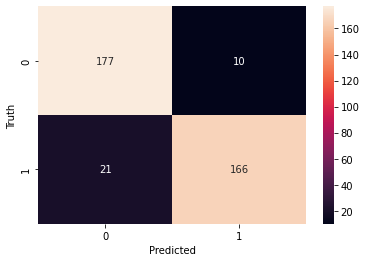

In [32]:
# plot the confusion metrics
from matplotlib import pyplot as plt 
import seaborn as sn 
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


### not spam = 177 correct, predict wrong 10 times
 predict spam = 166 correct, predict wrong 21 times

* True Positive = 177
* False Positive = 10
* False Negative = 21
* True Negative = 166




In [33]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       187
           1       0.94      0.89      0.91       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



In [34]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.73295075],
       [0.77845126],
       [0.7469421 ],
       [0.14395867],
       [0.07884301]], dtype=float32)

In [35]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [37]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	keras_metadata.pb  saved_model.pb  variables


In [38]:
# load my model
new_model = tf.keras.models.load_model('saved_model/my_model')

# Check its architecture
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [39]:
# use new_model to predicted review
new_model.predict(reviews)

array([[0.73295075],
       [0.77845126],
       [0.7469421 ],
       [0.14395867],
       [0.07884301]], dtype=float32)

In [40]:
# zip model
!zip -r spammodel.zip saved_model/my_model

  adding: saved_model/my_model/ (stored 0%)
  adding: saved_model/my_model/variables/ (stored 0%)
  adding: saved_model/my_model/variables/variables.index (deflated 79%)
  adding: saved_model/my_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/my_model/saved_model.pb (deflated 92%)
  adding: saved_model/my_model/assets/ (stored 0%)
  adding: saved_model/my_model/assets/vocab.txt (deflated 53%)
  adding: saved_model/my_model/keras_metadata.pb (deflated 84%)


In [41]:
# use this library to download zip file saved model
from google.colab import files


In [43]:
files.download('spammodel.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>